# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

^C
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [58 lines of output]
      Traceback (most recent call last):
        File "C:\Users\rishi\AppData\Local\Temp\pip-build-env-10zxcv5z\overlay\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\rishi\AppData\Local\Temp\pip-build-env-10zxcv5z\overlay\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\rishi\AppData\Local\Temp\pip-build-env-10zxcv5z\overlay\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


### 1.2 Collect Images Using OpenCV

In [19]:
import os 
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
# Ensure output directory exists
os.makedirs(IMAGES_PATH, exist_ok=True)

# Try primary camera index, fall back to 0 if unavailable
cap = cv2.VideoCapture(1)
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError("Could not open any video capture device.")

for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))

    # read frame and validate
    ret, frame = cap.read()
    if not ret or frame is None or frame.size == 0:
        # retry a few times before skipping
        retries = 0
        while retries < 5 and (not ret or frame is None or frame.size == 0):
            time.sleep(0.2)
            ret, frame = cap.read()
            retries += 1

        if not ret or frame is None or frame.size == 0:
            print(f'Warning: failed to capture frame for image {imgnum}, skipping.')
            continue

    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)

    # allow GUI events and handle quit key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    time.sleep(0.5)

cap.release()
cv2.destroyAllWindows()

In [ ]:
# Use Jupyter magic to install packages; don't call pip as a Python statement
%pip install --upgrade pip
%pip install labelme




Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

'labelme' is not recognized as an internal or external command,
operable program or batch file.


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [18]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU') # gets the list of all GPUs available like gpus = [physiscal device for GPU1, physiscal device for GPU2, ...]
for gpu in gpus: # gpu = current physiscal device of gpu say GPU0, GPU1, ...
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)  # means starting memory allocation is small not like standard alloaction of tensorflow for gpu, it grows dynmically as needed to prevent out of memeory errors

In [ ]:
if tf.config.list_physical_devices('GPU'):
  print("GPU is available")
else:
  print("GPU NOT available")
  # my comupter does not have an explicit gpu

GPU NOT available


### 2.3 Load Image into TF Data Pipeline

In [ ]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')
print(images.__len__())
# 90 images are found.


tf.Tensor(90, shape=(), dtype=int64)


In [ ]:
images.as_numpy_iterator().next()

b'data\\images\\1d56d66d-dd76-11f0-bded-00090ffe0001.jpg'

In [20]:
def load_image(x): 
    byte_img = tf.io.read_file(x) # read the image file 
    img = tf.io.decode_jpeg(byte_img)
    print(img.shape)
    return img

In [ ]:
images = images.map(load_image)

(None, None, None)


In [ ]:
images.as_numpy_iterator().next()

array([[[ 98, 104, 102],
        [ 98, 104, 102],
        [ 97, 103, 101],
        ...,
        [112, 138, 153],
        [110, 138, 150],
        [110, 138, 150]],

       [[ 96, 102, 100],
        [ 96, 102, 100],
        [ 96, 102, 100],
        ...,
        [111, 137, 152],
        [109, 137, 149],
        [109, 137, 149]],

       [[ 99, 105, 103],
        [ 99, 105, 103],
        [ 98, 104, 104],
        ...,
        [110, 138, 152],
        [109, 137, 149],
        [108, 136, 148]],

       ...,

       [[ 39,  33,  35],
        [ 39,  33,  35],
        [ 38,  32,  34],
        ...,
        [ 62, 108, 123],
        [ 65, 113, 127],
        [ 65, 113, 127]],

       [[ 37,  31,  33],
        [ 37,  31,  33],
        [ 38,  32,  34],
        ...,
        [ 61, 107, 122],
        [ 66, 114, 128],
        [ 66, 114, 128]],

       [[ 35,  29,  31],
        [ 36,  30,  32],
        [ 37,  31,  33],
        ...,
        [ 60, 106, 121],
        [ 66, 114, 128],
        [ 66, 114, 128]]

In [ ]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

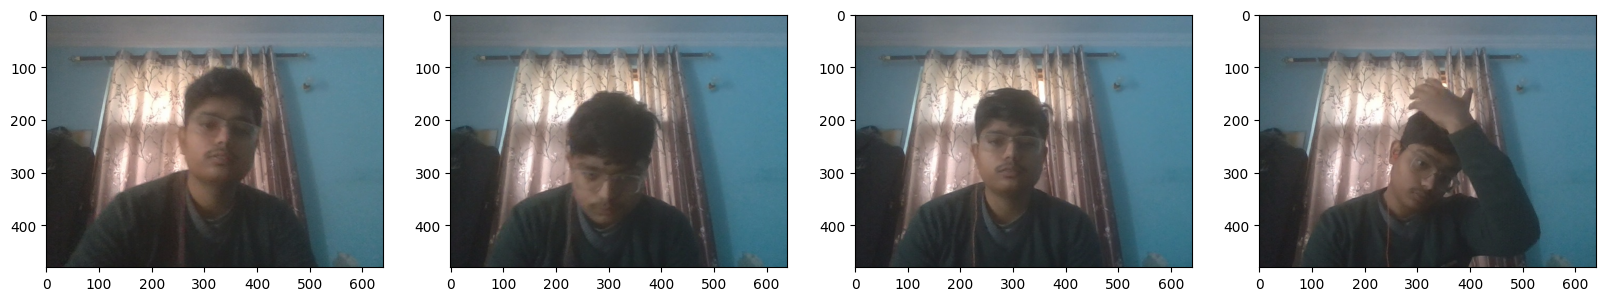

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

62.99999999999999

In [ ]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [ ]:
%pip install albumentations
import albumentations as alb

Note: you may need to restart the kernel to use updated packages.


c:\Users\rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
img = cv2.imread(os.path.join('data','train', 'images','1b7bbf96-dd76-11f0-9fe9-00090ffe0001.jpg'))

In [ ]:
with open(os.path.join('data', 'train', 'labels', '1b7bbf96-dd76-11f0-9fe9-00090ffe0001.json'), 'r') as f:
    label = json.load(f)

In [ ]:
label['shapes'][0]['points']

[[176.12745098039213, 84.11764705882354],
 [386.42156862745094, 358.1372549019608]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

[176.12745098039213, 84.11764705882354, 386.42156862745094, 358.1372549019608]

In [ ]:
coords = list(np.divide(coords, [640,480,640,480]))

In [ ]:
coords

[np.float64(0.2751991421568627),
 np.float64(0.1752450980392157),
 np.float64(0.6037837009803921),
 np.float64(0.7461192810457516)]

### 4.4 Apply Augmentations and View Results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes'][0][2:]

[0.8330501047770182, 0.8597385692596435]

In [ ]:
augmented['bboxes']

[[0.36572981092664936,
  0.2508061218261719,
  0.8330501047770182,
  0.8597385692596435]]

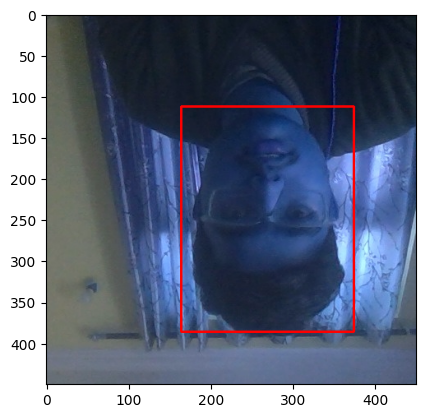

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [15]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(30):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'au

### 5.2 Load Augmented Images to Tensorflow Dataset

In [21]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

(None, None, None)


In [22]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

(None, None, None)


In [23]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

(None, None, None)


In [24]:
train_images.as_numpy_iterator().next()

array([[[0.15888481, 0.12996323, 0.0716299 ],
        [0.16550244, 0.1341299 , 0.08351716],
        [0.15      , 0.11372549, 0.07303922],
        ...,
        [0.22218138, 0.26531863, 0.23394608],
        [0.21041666, 0.25845587, 0.23186274],
        [0.21458334, 0.26139706, 0.23602942]],

       [[0.15539216, 0.12303922, 0.08088236],
        [0.16078432, 0.12849265, 0.08633579],
        [0.16378677, 0.12849265, 0.09319853],
        ...,
        [0.22377451, 0.25906864, 0.24044117],
        [0.21133578, 0.25349265, 0.23143382],
        [0.23125   , 0.27340686, 0.25073528]],

       [[0.1564951 , 0.11727941, 0.08198529],
        [0.17254902, 0.13333334, 0.09803922],
        [0.15784314, 0.12254902, 0.0872549 ],
        ...,
        [0.21875   , 0.25404412, 0.24227941],
        [0.23333333, 0.26862746, 0.25686276],
        [0.25220588, 0.28014705, 0.26593137]],

       ...,

       [[0.43707108, 0.33952206, 0.2821691 ],
        [0.44148284, 0.35128677, 0.2963848 ],
        [0.4471201 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [25]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [26]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [27]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [28]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2136, 0.2598, 0.681 , 0.8687], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [30]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1890, 1890, 420, 420, 390, 390)

### 7.2 Create Final Datasets (Images/Labels)

In [31]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [32]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [33]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [34]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.0832 , 0.1404 , 0.5483 , 0.695  ],
        [0.6333 , 0.1877 , 1.     , 0.8643 ],
        [0.403  , 0.2114 , 0.864  , 0.7026 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2415 , 0.2834 , 0.626  , 0.728  ],
        [0.1937 , 0.2313 , 0.695  , 0.7095 ],
        [0.2483 , 0.298  , 0.609  , 0.8164 ],
        [0.10095, 0.281  , 0.4517 , 0.744  ]], dtype=float16))

### 7.3 View Images and Annotations

In [35]:
data_samples = train.as_numpy_iterator()

In [36]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


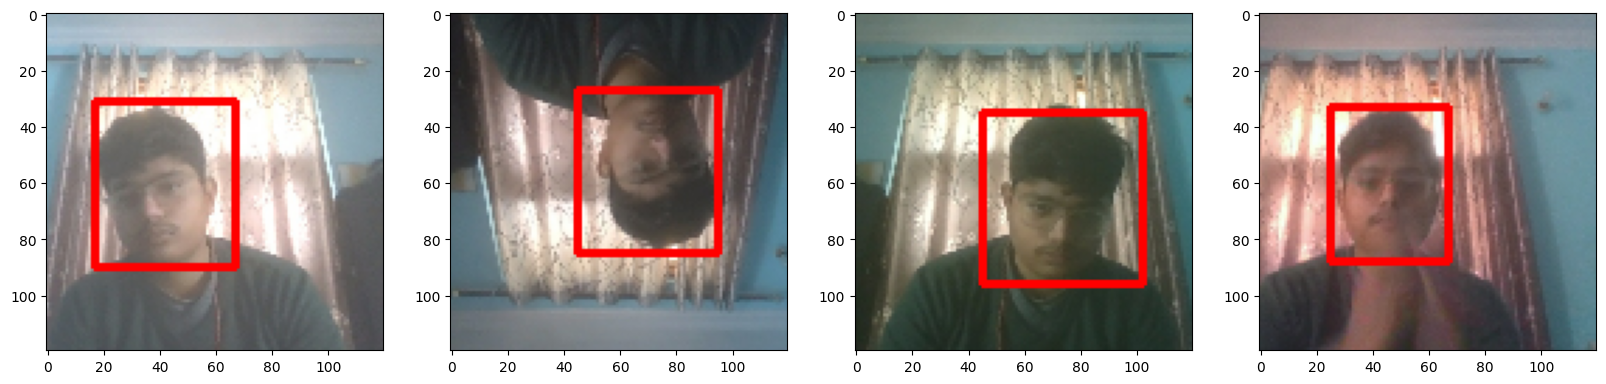

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = res[0][idx].copy()   # 🔑 FIX
    sample_coords = res[1][1][idx]

    cv2.rectangle(
        sample_image,
        tuple((sample_coords[:2] * [120, 120]).astype(int)),
        tuple((sample_coords[2:] * [120, 120]).astype(int)),
        (255, 0, 0),
        2
    )

    ax[idx].imshow(sample_image)

plt.show()


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [10]:
vgg = VGG16(include_top=False)

In [11]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [39]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [40]:
facetracker = build_model()

In [41]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [42]:
X, y = train.as_numpy_iterator().next()

In [43]:
X.shape

(8, 120, 120, 3)

In [44]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [44]:
classes, coords

(array([[0.2595985 ],
        [0.28928477],
        [0.28045478],
        [0.23134308],
        [0.21316376],
        [0.28604874],
        [0.20912272],
        [0.24797134]], dtype=float32),
 array([[0.45407173, 0.483605  , 0.5788658 , 0.50824505],
        [0.38608795, 0.45711905, 0.5739012 , 0.5020862 ],
        [0.48458773, 0.53571296, 0.5239781 , 0.5317807 ],
        [0.45363304, 0.46956462, 0.588616  , 0.53073615],
        [0.4347262 , 0.49403077, 0.5593719 , 0.50955826],
        [0.45091817, 0.6191479 , 0.49725437, 0.51203567],
        [0.3801335 , 0.47278282, 0.57616735, 0.49626276],
        [0.43559307, 0.4760778 , 0.5574897 , 0.5358599 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [45]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [64]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,decay=lr_decay)

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

### 9.2 Create Localization Loss and Classification Loss

In [50]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [51]:
model.loss
model.metrics
model.__class__

NameError: name 'model' is not defined

In [52]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [53]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.568576>

In [54]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7682866>

In [55]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.568576>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [65]:
class FaceTracker(tf.keras.Model): 
    def __init__(self, eyetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(run_eagerly=True, **kwargs)  # 👈 IMPORTANT
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [62]:
# model.loss
model.metrics
model.__class__

__main__.FaceTracker

In [58]:
model = FaceTracker(facetracker)

In [59]:
model.compile(opt, classloss, regressloss)

NameError: name 'opt' is not defined

### 10.2 Train

In [55]:
logdir='logs'

In [56]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
for x, y in train.take(1):
    print(type(y))
    print(len(y))
    print(y[0].shape)
    print(y[1].shape)


<class 'tuple'>
2
(8, 1)
(8, 4)


In [ ]:
tf.print("classes static shape:", classes.shape)
tf.print("classes dynamic shape:", tf.shape(classes))
model.build((None, 120, 120, 3))
model.summary()

classes static shape: (8, 1)
classes dynamic shape: [8 1]


Model: "face_tracker_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ ((None, 1), (None, 4)) │    16,826,181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:

# ensure fit_kwargs is defined (empty by default)
fit_kwargs = {}

hist = model.fit(train,
				 epochs=10,
				 validation_data=val,
				 callbacks=[tensorboard_callback],
				 **fit_kwargs)

Epoch 1/10


237/237 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - class_loss: 0.0506 - regress_loss: 0.0357 - total_loss: 0.0610 - val_class_loss: 2.7713 - val_regress_loss: 2.7243 - val_total_loss: 4.1099
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - class_loss: 0.0825 - regress_loss: 0.0363 - total_loss: 0.0775 - val_class_loss: 3.6472 - val_regress_loss: 3.5589 - val_total_loss: 5.3825
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - class_loss: 0.0032 - regress_loss: 0.0198 - total_loss: 0.0213 - val_class_loss: 2.7355 - val_regress_loss: 2.3652 - val_total_loss: 3.7330
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - class_loss: 7.1926e-04 - regress_loss: 0.0819 - total_loss: 0.0822 - val_class_loss: 7.4156 - val_regress_loss: 3.7456 - val_total_loss: 7.4534
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - class_loss: 2.0871e-06 - regress_loss: 0.0053 - total_loss: 0.0053 - val_class_loss: 6.2240 - val_regress_loss: 2.9486 - val_total_loss: 6.0606
Epoch 6/10
237/237 ━━━━━━━━━

### 10.3 Plot Performance

In [62]:
hist.history

{'class_loss': [0.05056823045015335,
  0.08254145085811615,
  0.003186544170603156,
  0.0007192562916316092,
  2.0871195829386124e-06,
  3.4494598367018625e-05,
  2.6501693725585938,
  0.00028839503647759557,
  0.00010915632446995005,
  0.0001341930910712108],
 'regress_loss': [0.035723548382520676,
  0.03627616912126541,
  0.01975567638874054,
  0.08188740909099579,
  0.005279413424432278,
  0.010587154887616634,
  0.31529974937438965,
  0.012634088285267353,
  0.00831458531320095,
  0.0015875028911978006],
 'total_loss': [0.06100766360759735,
  0.07754689455032349,
  0.021348947659134865,
  0.08224703371524811,
  0.005280456971377134,
  0.010604402050375938,
  1.6403844356536865,
  0.012778285890817642,
  0.008369163610041142,
  0.0016545994440093637],
 'val_class_loss': [2.7713053226470947,
  3.647170066833496,
  2.7354612350463867,
  7.415647029876709,
  6.224027156829834,
  6.655483245849609,
  5.907952785491943,
  3.4659347534179688,
  5.796350479125977,
  4.6187920570373535],
 '

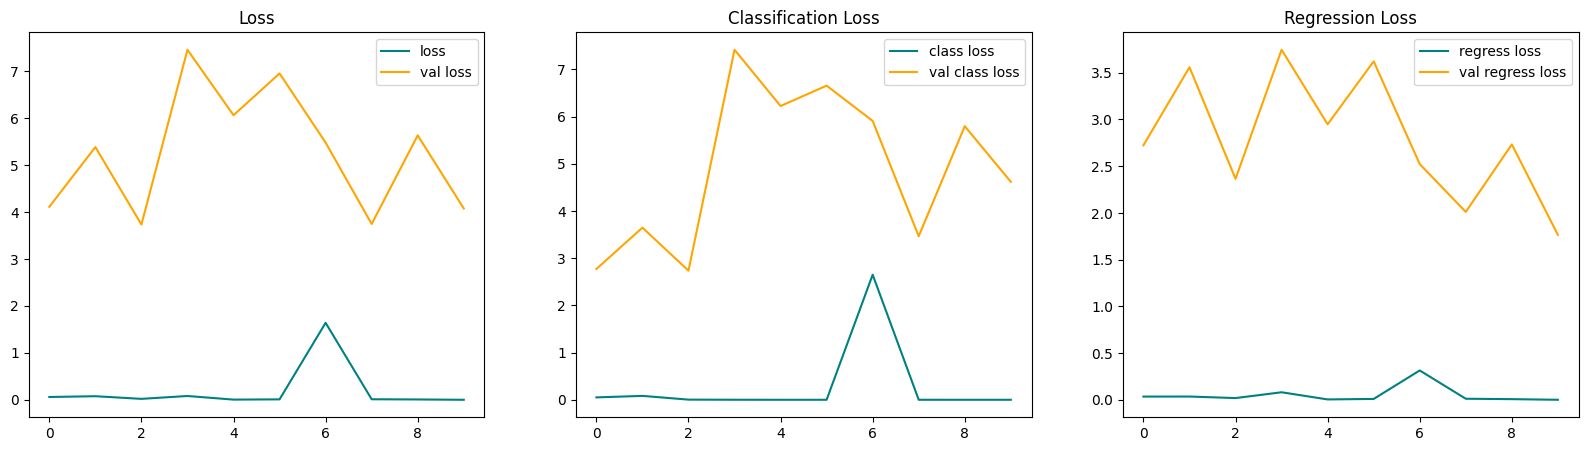

In [63]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [64]:
test_data = test.as_numpy_iterator()

In [65]:
test_sample = test_data.next()

In [66]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


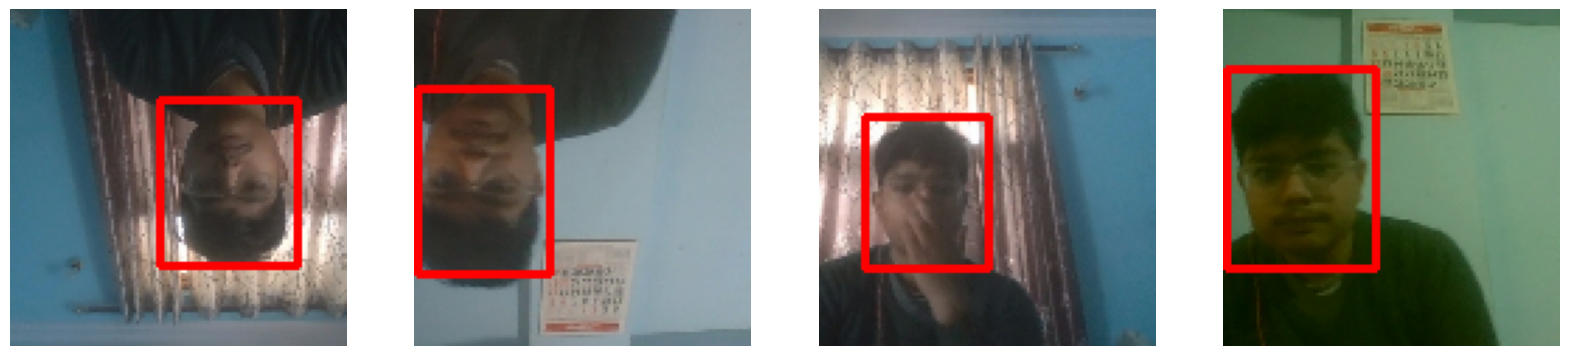

In [67]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    # Handle both TensorFlow tensors and NumPy arrays
    sample_image = test_sample[0][idx]
    if hasattr(sample_image, "numpy"):
        sample_image = sample_image.numpy()

    sample_image = sample_image.copy()  # make writable

    sample_coords = yhat[1][idx]
    if hasattr(sample_coords, "numpy"):
        sample_coords = sample_coords.numpy()

    if yhat[0][idx] > 0.9:
        x1, y1 = (sample_coords[:2] * [120, 120]).astype(int)
        x2, y2 = (sample_coords[2:] * [120, 120]).astype(int)

        cv2.rectangle(
            sample_image,
            (x1, y1),
            (x2, y2),
            (255, 0, 0),
            2
        )

    ax[idx].imshow(sample_image)
    ax[idx].axis("off")

plt.show()


### 11.2 Save the Model

In [68]:
from tensorflow.keras.models import load_model

In [11]:
facetracker.save('facetracker.h5')

In [71]:
facetracker = load_model('facetracker.h5')

In [1]:
pip uninstall opencv-python opencv-python-headless -y


Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
Note: you may need to restart the kernel to use updated packages.


In [72]:
facetracker.save("facetracker_model_new.keras")



In [2]:
pip install opencv-python


  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Note: you may need to restart the kernel to use updated packages.


### 11.3 Real Time Detection

In [13]:
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame is None:
        continue
        # print("Frame not received")
        # break


    frame = frame[50:500, 50:500, :]

    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    # cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

NameError: name 'self' is not defined

In [3]:
pip install streamlit opencv-python


Note: you may need to restart the kernel to use updated packages.


In [4]:
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf

st.set_page_config(layout="wide")
st.title("Real-Time Face Detection")

# Load model (make sure facetracker is loaded correctly)
# facetracker = tf.keras.models.load_model("your_model_path")

run = st.checkbox("Run Camera")
FRAME_WINDOW = st.image([])

cap = cv2.VideoCapture(0)

while run:
    ret, frame = cap.read()
    if not ret:
        st.warning("Camera not detected")
        break

    frame = frame[50:500, 50:500]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120)) / 255.0

    yhat = facetracker(
        tf.expand_dims(resized, axis=0),
        training=False
    )

    confidence = yhat[0][0]
    coords = yhat[1][0].numpy()

    if confidence > 0.5:
        h, w, _ = frame.shape
        x1, y1 = (coords[:2] * [w, h]).astype(int)
        x2, y2 = (coords[2:] * [w, h]).astype(int)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(
            frame, f"Face {confidence:.2f}",
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255,255,255),
            2
        )

    FRAME_WINDOW.image(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

cap.release()


2025-12-23 19:32:31.108 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 19:32:31.109 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 19:32:33.084 
  command:

    streamlit run C:\Users\rishi\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-23 19:32:33.085 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 19:32:33.086 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 19:32:33.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 19:32:33.087 Thread 'MainThread': missing ScriptRunContext! This warning can b

In [2]:
# Ensure a protobuf version compatible with mediapipe is installed first
# force-reinstall to make sure the correct protobuf is used
%pip install -q --upgrade --force-reinstall protobuf==3.20.3 mediapipe

import importlib
import sys

# verify protobuf version before importing mediapipe to avoid the runtime_version import error
try:
	import google.protobuf as gp
	print("protobuf version (pre-check):", gp.__version__)
except Exception:
	# If google.protobuf is not importable yet, try to (re)install and reload
	%pip install -q --upgrade --force-reinstall protobuf==3.20.3
	importlib.invalidate_caches()
	try:
		import google.protobuf as gp
		print("protobuf version (post-install):", gp.__version__)
	except Exception as e:
		raise SystemExit("Failed to import google.protobuf. Please restart the kernel and re-run the notebook.") from e

# If the version is still not the pinned one, ask for a kernel restart (required in many Jupyter environments)
if gp.__version__ != "3.20.3":
	print(f"Detected protobuf {gp.__version__} (expected 3.20.3).")
	raise SystemExit("Please restart the notebook kernel and re-run after the protobuf reinstall to ensure mediapipe imports cleanly.")

# Now it's safe to import the rest
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import time
import math

print("mediapipe and protobuf should now import without the runtime_version error.")


^C
Note: you may need to restart the kernel to use updated packages.
protobuf version (pre-check): 3.20.3


ImportError: cannot import name 'runtime_version' from 'google.protobuf' (c:\Users\rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\__init__.py)

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.0 which is incompatible.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 3.20.3 which is incompatible.


In [1]:
model = tf.keras.models.load_model("facetracker_model_new.keras")


NameError: name 'tf' is not defined

In [3]:
%pip install mediapipe==0.10.9



Note: you may need to restart the kernel to use updated packages.


In [2]:
import mediapipe as mp
print(mp.__version__)
print(hasattr(mp, "solutions"))


ImportError: cannot import name 'runtime_version' from 'google.protobuf' (c:\Users\rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\__init__.py)

In [7]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)


NameError: name 'mp' is not defined

In [2]:
pip install mediapipe opencv-python numpy pandas streamlit tensorflow

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/12.9 MB 6.7 MB/s eta 0:00:02
   ----------- ---------------------------- 3.7/12.9 MB 9.1 MB/s eta 0:00:02
   ----------------- ---------------------- 5.5/12.9 MB 9.3 MB/s eta 0:00:01
   ----------------------- ---------------- 7.6/12.9 MB 9.4 MB/s eta 0:00:01
   ------------------------------ --------- 9.7/12.9 MB 9.4 MB/s eta 0:00:01
   ------------------------------------ --- 11.8/12.9 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 9.2 MB/s  0:00:01

  Attempting uninstall: protobuf

    Found existing installation: protobuf 3.20.3

    Uninstalling protobuf-3.20.3:

   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
